**Desafío - Prediciendo los precios de las casas**

#**0.Importamos las librerias**

In [ ]:
import pandas as pd
import numpy as np
#Visualizacion
import matplotlib.pyplot as plt
import seaborn as sns
#Estandarización, KFold y split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold
#Modelos ML
import sklearn
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
#Metricas de evaluacion
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, GridSearchCV
#Math
from math import sqrt
#Drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**1.Analizar la calidad de datos, para lo que debes cargarlos y realizar un proceso exhaustivo de limpieza para eliminar valores faltantes, duplicados y atípicos que puedan afectar la calidad del modelo, si los hay.**

In [ ]:
df = pd.read_excel("/content/drive/My Drive/Colab Notebooks/Machine Learning/5.Aprendizaje supervisado y no supervisado Parte IV/Desafio/house_data.xlsx")

In [ ]:
print(df.shape) #21613, 21
df.head()

(21613, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  int64  
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

**Podemos ver que el dataset no contiene valores nulos, pero si serán necesarias algunas transformaciones de variables ya que estan en formatos incorrectos**

Todos los codigos zip/postales corresponden a ciudades dentro del estado de Washington DC y debido a las caracteristicas de ese pais en cuanto a densidad de poblacion y extensión, es que hay varios codigos postales por la misma ciudad, las cuales recodificaremos para entender de mejor manera esta variable viendo sus nombres.

In [ ]:
zipcode_to_city = {98178: "Seattle", 98125: "Seattle",98028: "Kenmore",98136: "Seattle",98074: "Sammamish",98053: "Redmond",98198: "Des Moines",98146: "Seattle",
    98038: "Maple Valley",98007: "Bellevue",98115: "Seattle",98107: "Seattle",98126: "Seattle",98019: "Duvall",98103: "Seattle",98002: "Auburn",98133: "Seattle",
    98040: "Mercer Island",98092: "Auburn",98030: "Kent",98119: "Seattle",98112: "Seattle",98052: "Redmond",98027: "Issaquah",98117: "Seattle",98058: "Renton",
    98001: "Auburn",98056: "Renton",98166: "Seattle",98023: "Federal Way",98070: "Vashon",98148: "Seattle",98105: "Seattle",98042: "Kent",98008: "Bellevue",98059: "Renton",
    98122: "Seattle",98144: "Seattle",98004: "Bellevue",98005: "Bellevue",98034: "Kirkland",98075: "Sammamish",98116: "Seattle",98010: "Black Diamond",98118: "Seattle",
    98199: "Seattle",98032: "Kent",98045: "North Bend",98102: "Seattle",98077: "Woodinville",98108: "Seattle",98168: "Seattle",98177: "Seattle",98065: "Snoqualmie",
    98029: "Issaquah",98006: "Bellevue",98109: "Seattle",98022: "Enumclaw",98033: "Kirkland",98155: "Seattle",98024: "Fall City",98011: "Bothell",98031: "Kent",
    98106: "Seattle",98072: "Woodinville",98188: "Seattle",98014: "Carnation",98055: "Renton",98039: "Medina",98003:"Federal Way"}

df["city"] = df["zipcode"].replace(zipcode_to_city) #Creamos la columna utilizando el dict creado
df = df.drop(columns="zipcode") #Dropeamos la columna zipcode que ya no utilizaremos

In [ ]:
df["last_renovate_yr"] = np.where(df["yr_renovated"] == 0, 0, (df["yr_built"] - df["yr_renovated"])) #Recodificamos last_renovate, calculando hace cuantos años fue su ultima renovacion
df = df.drop(columns="yr_renovated")

Revisamos los valores unicos para detectar anomalias sobre todo las que no catalogan como outliers, si no que registros mal enterados.

In [ ]:
for column in df.columns:
  if column not in ["lat","long"]:
    print(f"La columna {column} tiene los siguientes valores:")
    print(df[column].unique())
    print("")

**Luego de esa revisión de valores unicos, la que principalmente nos sirve para revisar si existen valores anormales, haremos un drop o transformaiones de algunos registros que presentan esta condicion, para luego visualizar las columnas con la data anteriormente printeada.**

Consideraciones luego de esa primera revision:

*   Id debido a la gran cantidad de valores unicos, y que no necesariamente representan una magnitud matematica, no parece ser relevante a priori.
*   Date: debe ser transformada a datetime o separada
*   Bathrooms: Como arquitecto, teniendo conocimientos del negocio puedo afirmar que no existen las expresiones de cantidad de baños como 7.25, etc. Solo se consideran baños completos (con ducha) como integers y como "medios baños" los baños que no poseen ducha, por lo tanto eliminaremos los que terminan con .25 o .75.
*   floors: Se expresan como floats, indicando que se utiliza la mansarda como "medio piso", por lo que se mantendrán los floats.
*   sqft living, sqft lot, sqft_above, sqft_basement , sqft_living15 y sqft_lot15  : tranformaremos a m2, ya que los pies cuadrados no son metricas que sean muy amigables en este lado del continente.

-

**Transformaremos los pies cuadrados a metros cuadrados,
considerando que 1 metro cuadrado = 10.7639 pies cuadrados**

In [ ]:
sqft = 10.7639
df["sqft_living"] =  round((df["sqft_living"]/sqft),2)
df["sqft_lot"] =  round((df["sqft_lot"]/sqft),2)
df["sqft_above"] =  round((df["sqft_above"]/sqft),2)
df["sqft_basement"] =  round((df["sqft_basement"]/sqft),2)
df["sqft_living15"] =  round((df["sqft_living15"]/sqft),2)
df["sqft_lot15"] =  round((df["sqft_lot15"]/sqft),2)

Por lógica, una vivienda no puede tener menos de 1 baño completo (con ducha), por lo tanto ese será nuestro valor minimo, además de dropear los que ya comentamos anteriormente, los que terminan en .25 y .75 al no ser medios baños.

In [ ]:
bath_wrong = [0.0, 0.5, 0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25, 5.75, 6.25, 6.75, 7.75] #Definimos los valores de baños que son erroneos

In [ ]:
quest = df.query("bathrooms in @bath_wrong")
print(quest.shape)

(7243, 21)


Como podemos ver, existen 7243 registros mal anotados sobre baños con las condiciones que asumimos arriba, por lo que en vez de dropearlos, (ya que son aproximadamente el 25% de la data, los ajustaremos hacia abajo, ajustando los .25 hacia el entero inferior y los .75 al .5 inferior.



*   Ejemplo 1 = Si bathroom = 2.25 , entonces lo ajustamos a 2
*   Ejemplo 2 = Si bathroom = 2.75 , entonces lo ajustamos a 2.5

Con esta lógica, primero no perderemos gran cantidad de data y por otra parte, ajustamos valores que no necesariamente representan algo, como 2.75 baños, ya que es poco interpretable y no común en el contexto del negocio inmobiliario, sin embargo, si eliminaremos los que son menores a 1, por razones logicas y antes explicadas.



In [ ]:
df = df.drop(df[df.bathrooms < 1.0].index) #Dropeamos los registros con baños menores a 1

In [ ]:
#Para remplazar según lo que definimos más arriba, crearemos un diccionario para el replace
bath_dic = {1.25 : 1.0, 1.75 : 1.5 , 2.25 : 2.0, 2.75 : 2.5 , 3.25 : 3.0 , 3.75 : 3.5 , 4.25 : 4.0 , 4.75 : 4.50 , 5.25 : 5.0, 5.75 : 5.50 , 6.25 : 6.0, 6.75 : 6.50 , 7.75 : 7.50}

df["bathrooms"] = df["bathrooms"].replace(bath_dic) #Remplazamos

**Recodificaremos la fecha**

In [ ]:
df["date"] = df["date"].str.slice(stop=8) #Primero debemos cortar el string porque viene con unos caracteres que no estan aportando
df["date"] = pd.to_datetime(df["date"],format='%Y%m%d') #Transformamos de string a datetime

In [ ]:
#Renombramos las columnas para que coincidan con las transformaciones que hicimos
new_names = {"price":"price_k_usd","sqft_living":"m2_house","sqft_lot":"m2_lot","grade":"rating","sqft_above":"m2_above","sqft_basement":"m2_basement","sqft_living15":"m2_house15","sqft_lot15":"m2_lot15"}
df = df.rename(columns=new_names)

**Con el objetivo de poder visualizar mejor el precio de las casas, ajustaremos los valores en Miles de dolares**

In [ ]:
df["price_k_usd"] = df["price_k_usd"]/1000

**Crearemos otras variables**

In [ ]:
df["price_m2"] = round(df["price_k_usd"]/df["m2_house"],2) #Creamos precio por metro cuadrado

#**2.Realizar un análisis descriptivo de las variables para entender la distribución de los datos y detectar posibles relaciones entre las características y los precios. En esto debes incluir un análisis de correlaciones entre las variables principalmente con el precio de las casas**

Ahora realizaremos visualización de los datos para ver si existen outlier (para limpiarlos) y ver su distribución.

In [ ]:
#Separamos en las que son del tipo "booleanas" o que representan algun tipo de variable discreta, de las que son continuas y que tienen una desviacion y distribución más amplia como m2s.
num_disc = df[['bedrooms','bathrooms','floors', 'waterfront', 'view', 'condition', 'rating','yr_built']]
num_cont = df[['price_k_usd','m2_house','m2_lot','m2_above','m2_basement','m2_house15', 'm2_lot15','price_m2','last_renovate_yr']]

In [ ]:
def get_hist(df,n_rows):
  num = df.shape[1]
  rows = n_rows
  cols = (num+rows-1)//rows
  fig, axs = plt.subplots(rows,cols,figsize=(23,13))

  for index, colname in enumerate(df.columns):
    mean = df[colname].mean()
    median = df[colname].median()
    std_low = mean-df[colname].std()
    std_upper = mean+df[colname].std()

    plt.subplot(rows,cols,index+1)
    sns.histplot(df[colname],kde=True,alpha=0.2,lw=0.2)
    plt.axvline(mean,color="red",ls="dashed",label=f"Mean {round(mean,2)}")
    plt.axvline(median,color="orange",ls="dotted",label=f"Median {round(median,2)}")
    plt.axvline(std_low,color="orange",ls="dotted",label=f"std_low {round(std_low,2)}")
    plt.axvline(std_upper,color="orange",ls="dotted",label=f"std_upper {round(std_upper,2)}")
    plt.title(f"{colname} distribution")
    plt.legend()
  plt.tight_layout()
  plt.show()

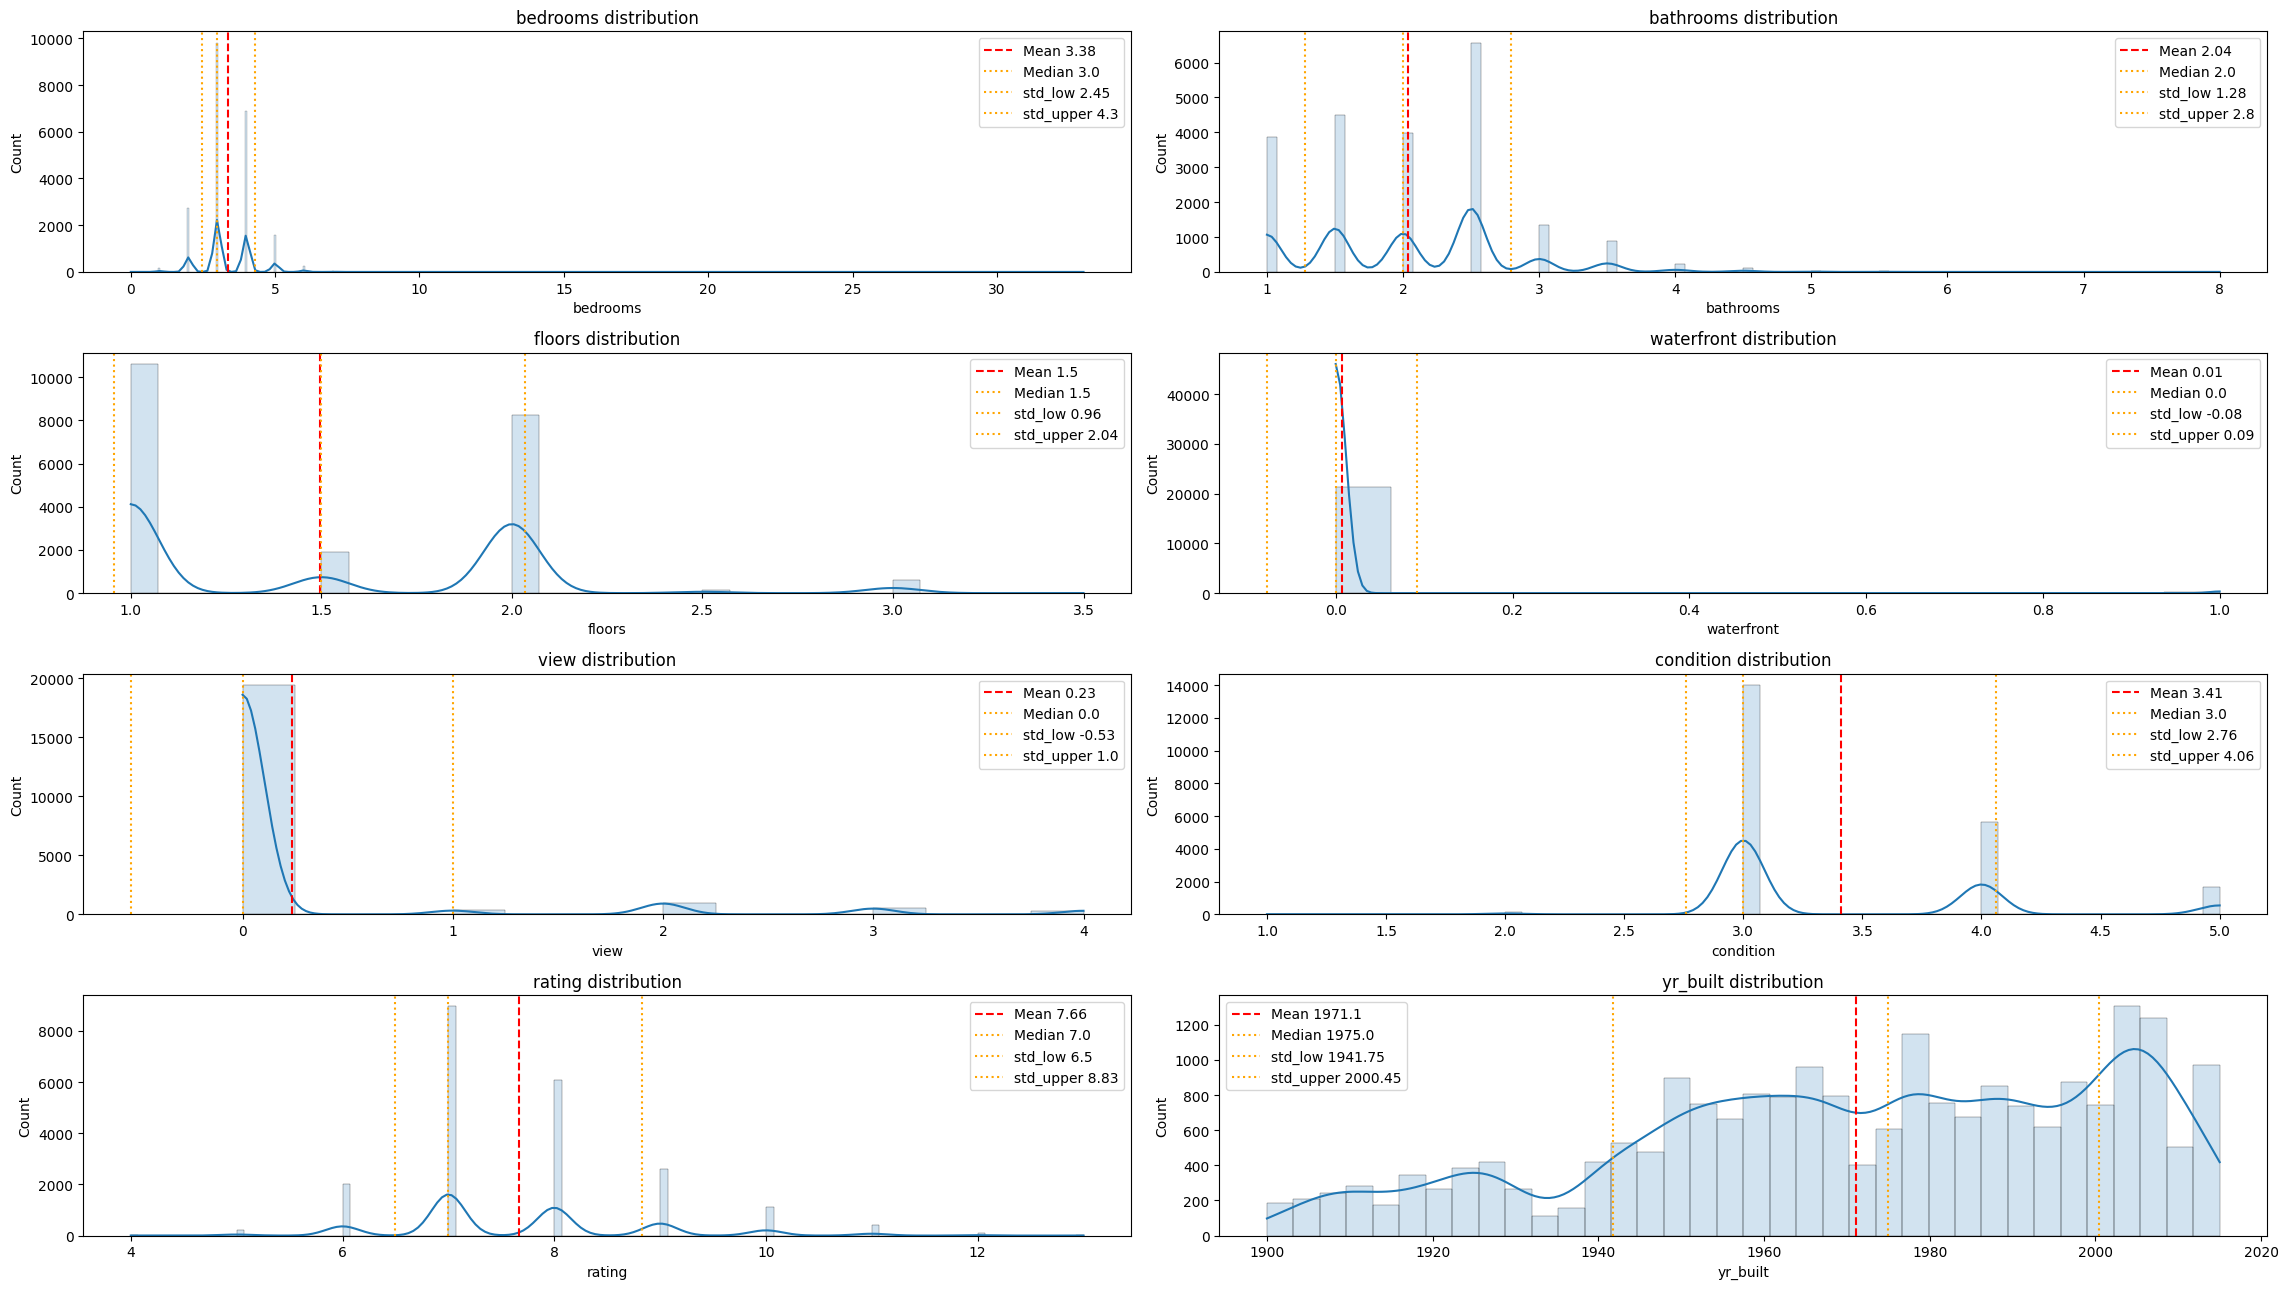

In [ ]:
get_hist(num_disc,4)

**Tanto beedrooms como bathrooms tienen valores que podrian considerarse extremos que hacen que la distribución tienda a sesgarse a la derecha, las variables como floor ya fueron ajustadas anteriormente y el resto presentan valores normales dentro de la naturaleza de lo que representan.**

Hallazgos

*   Promedio de dormitorios = 3
*   Promedio de baños = 2
*   Rango de pisos 1-2
*   La mayoria no cuenta con fuente
*   Promedio de vistas bastante malo, cercano a 0
*   La condicion promedio es 3.5 de un maximo de 5, no es mala.
*   Rating promedio de 7

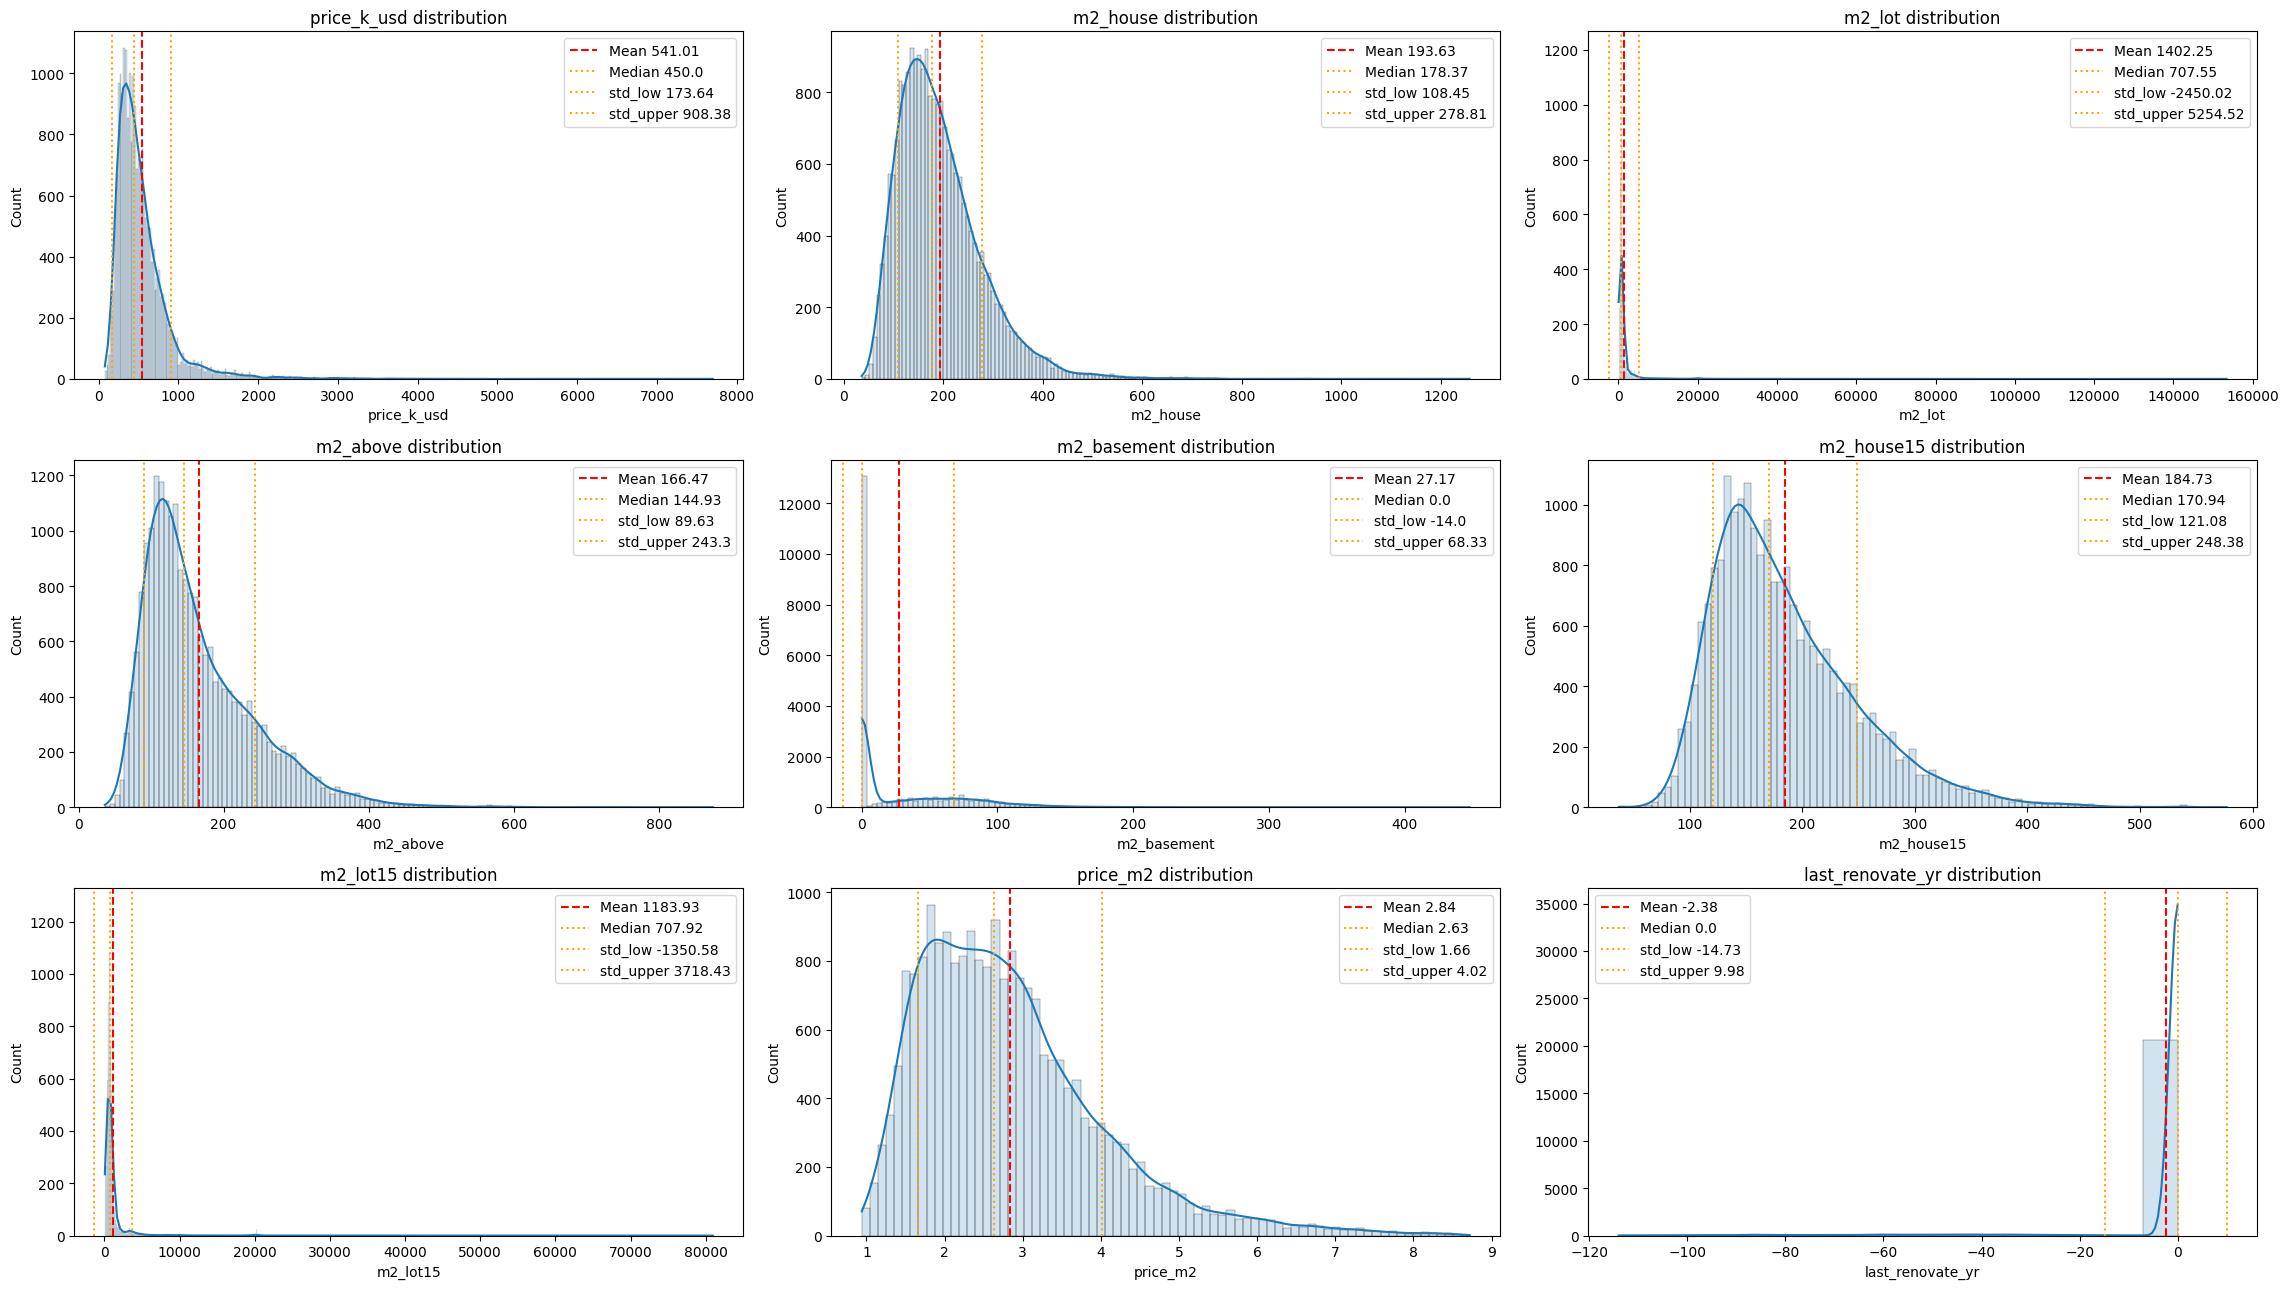

In [ ]:
get_hist(num_cont,3)

**Como podemos apreciar, casi todas las variables continuas presentan un sesgo marcado hacia la derecha, lo que nos indica una alta presencia de valores extremos en estas variables, sobre todo en price y house distributión. Sobre la columna creada de last renovate year, la distribución es inversa ya que cuenta hacia atraas la cantidad de años desde la ultima remodelacion, y podemos ver que la mayoria de las casas no cuentan con una.**



*   Precio promedio de 540k usd, con bastante desviacion estandar
*   Superficie promedio de 193 m2
*   Superficie promedio sobre tierra de 166 m2 y bajo tierra de 27m2
*   Valor/m2 promedio de 2839/m2

**Importante indicar que una vez limpiados los outliers, se espera que los promedios se vean afectados notablemente y su desviacion estandar.

**Limpiamos outliers**
**Utilizamos una limpieza de todos los datos que se encuentren a más de 3 desviaciones estandar, ya que a través de percentiles no se lograron buenos resultados.**

In [ ]:
#Definimos las columnas que por su naturaleza pueden tener outliers, según lo que vimos más arriba
cols_to_clean = ['price_k_usd', 'm2_house', 'm2_lot', 'm2_above', 'm2_basement', 'm2_house15', 'm2_lot15', 'price_m2', 'last_renovate_yr',"bedrooms","bathrooms"]


def clean_outliers_std(df, cols, threshold=3):
    df_clean = df.copy()
    for column in cols:
        # Calcula la media y la desviación estándar de la columna
        mean = df[column].mean()
        std = df[column].std()

        # Calcula los límites para detectar outliers
        lower_bound = mean - threshold * std
        upper_bound = mean + threshold * std

        # Filtra los outliers
        df_clean = df_clean[(df_clean[column] >= lower_bound) & (df_clean[column] <= upper_bound)]

    return df_clean

df_clean = clean_outliers_std(df,cols_to_clean)

old_shape = df.shape[0]
new_shape = df_clean.shape[0]
print(f"El dataset luego de la limpieza de outliers, pasó de {old_shape} registros a tener {new_shape}")

El dataset luego de la limpieza de outliers, pasó de 21527 registros a tener 19383


**Graficaremos correlaciones**

In [ ]:
df_clean_to_corr = df_clean.drop(columns=["id","date","city","waterfront","lat","long"]) #Dropeamos las columnas que no queremos visualizar por su naturaleza
pearson_corr = df_clean_to_corr.corr(method='pearson')

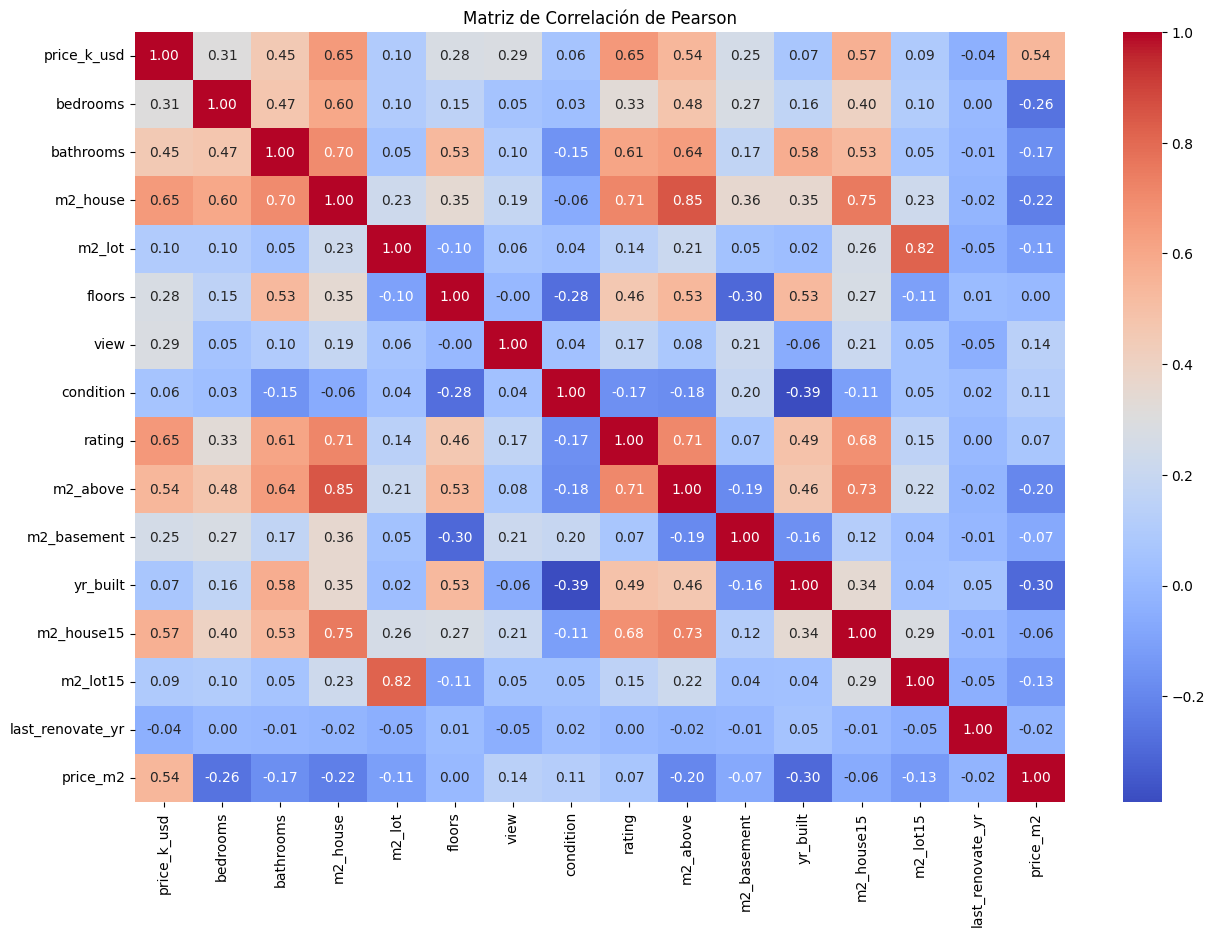

In [ ]:
#Visualizamos
plt.figure(figsize=(15, 10))
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlación de Pearson")
plt.show()


**Como podemos ver, la columna price tiene correlaciones positivas que no son tan potentes, con un maximo de 0.65, lo que de una u otra manera nos ayuda a que el modelo no se sobreajuste excesivamente debido a variables que indidivualmente son capaces de explicar la variabilidad de price.**

**Consideraremos todas las variables por sobre 0.50% de correlacion para intentar predecir price.**



**Hallazgos**:
**Interesante ver como la cantidad de dormitorios no presenta una correlacion lo suficientemente grande como para ser considerada, al igual que la cantidad de pisos y m2 basement (subterraneo), lo que puede deberse a que estos m2 bajo tierra generalmente son usados más como bodega que como m2 utiles.**

**Por otra parte, que m2_above solo tenga un 54% de correlacion, tambien es curioso, por decirlo menos, ya que el mercado inmobiliario de por si se rige por valores/m2**

In [ ]:
#Tomaremos las variables que serán definidas como predictoras y un par más para poder visualizar como se comportan por ciudades
by_city = df_clean.groupby(by="city").agg({ 'price_k_usd': "mean",
                                  'bedrooms':"median",
                                  'bathrooms':"median",
                                  'm2_house':"mean",
                                  'm2_lot':"mean",
                                  'rating':"median",
                                  'm2_above':"mean",
                                  'm2_house15':"mean",
                                  'price_m2':"mean"
                                }).round(2)
by_city

,price_k_usd,bedrooms,bathrooms,m2_house,m2_lot,rating,m2_above,m2_house15,price_m2
city,,,,,,,,,
Auburn,279.53,3.0,2.00,176.79,1110.52,7.0,164.42,171.49,1.62
Bellevue,719.53,4.0,2.00,216.45,1105.74,8.0,177.23,216.62,3.39
Black Diamond,384.54,3.0,1.50,185.86,2167.02,7.0,171.15,174.07,2.13
Bothell,488.68,3.0,2.50,207.60,952.72,8.0,180.96,205.94,2.44
Carnation,401.74,3.0,2.00,181.36,2559.78,7.0,170.40,162.02,2.29
Des Moines,295.03,3.0,1.50,160.15,976.19,7.0,135.22,159.10,1.89
Duvall,412.24,3.0,2.50,200.26,1243.63,7.0,190.33,198.13,2.13
Enumclaw,276.65,3.0,2.00,161.89,1634.43,7.0,153.94,159.46,1.80
Fall City,410.42,3.0,1.50,165.50,3136.03,7.0,152.19,165.64,2.65


**Visualizaremos esto:**

In [ ]:
def get_barplot(df):
  fig, axs = plt.subplots(3,3,figsize=(23,13))
  for index, colname in enumerate(df.columns):
    sns.barplot(x="city",y=colname,data=df,alpha=0.2,lw=0.2,ax=axs[index//3,index % 3],capsize=0.1)
    axs[index // 3, index % 3].set_xticklabels(axs[index // 3, index % 3].get_xticklabels(), rotation=90)
    axs[index // 3, index % 3].set_title(f"{colname.capitalize()} distribution")
  plt.tight_layout()
  plt.show()

<ipython-input-26-7af784412396>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[index // 3, index % 3].set_xticklabels(axs[index // 3, index % 3].get_xticklabels(), rotation=90)
<ipython-input-26-7af784412396>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[index // 3, index % 3].set_xticklabels(axs[index // 3, index % 3].get_xticklabels(), rotation=90)
<ipython-input-26-7af784412396>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[index // 3, index % 3].set_xticklabels(axs[index // 3, index % 3].get_xticklabels(), rotation=90)
<ipython-input-26-7af784412396>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[index // 3, index % 3].set_xticklabels(axs[index // 3, index % 3].get_xticklabels(), rotation=90)
<ipython-input-26-7af784412396>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[index // 3, index % 3].set_x

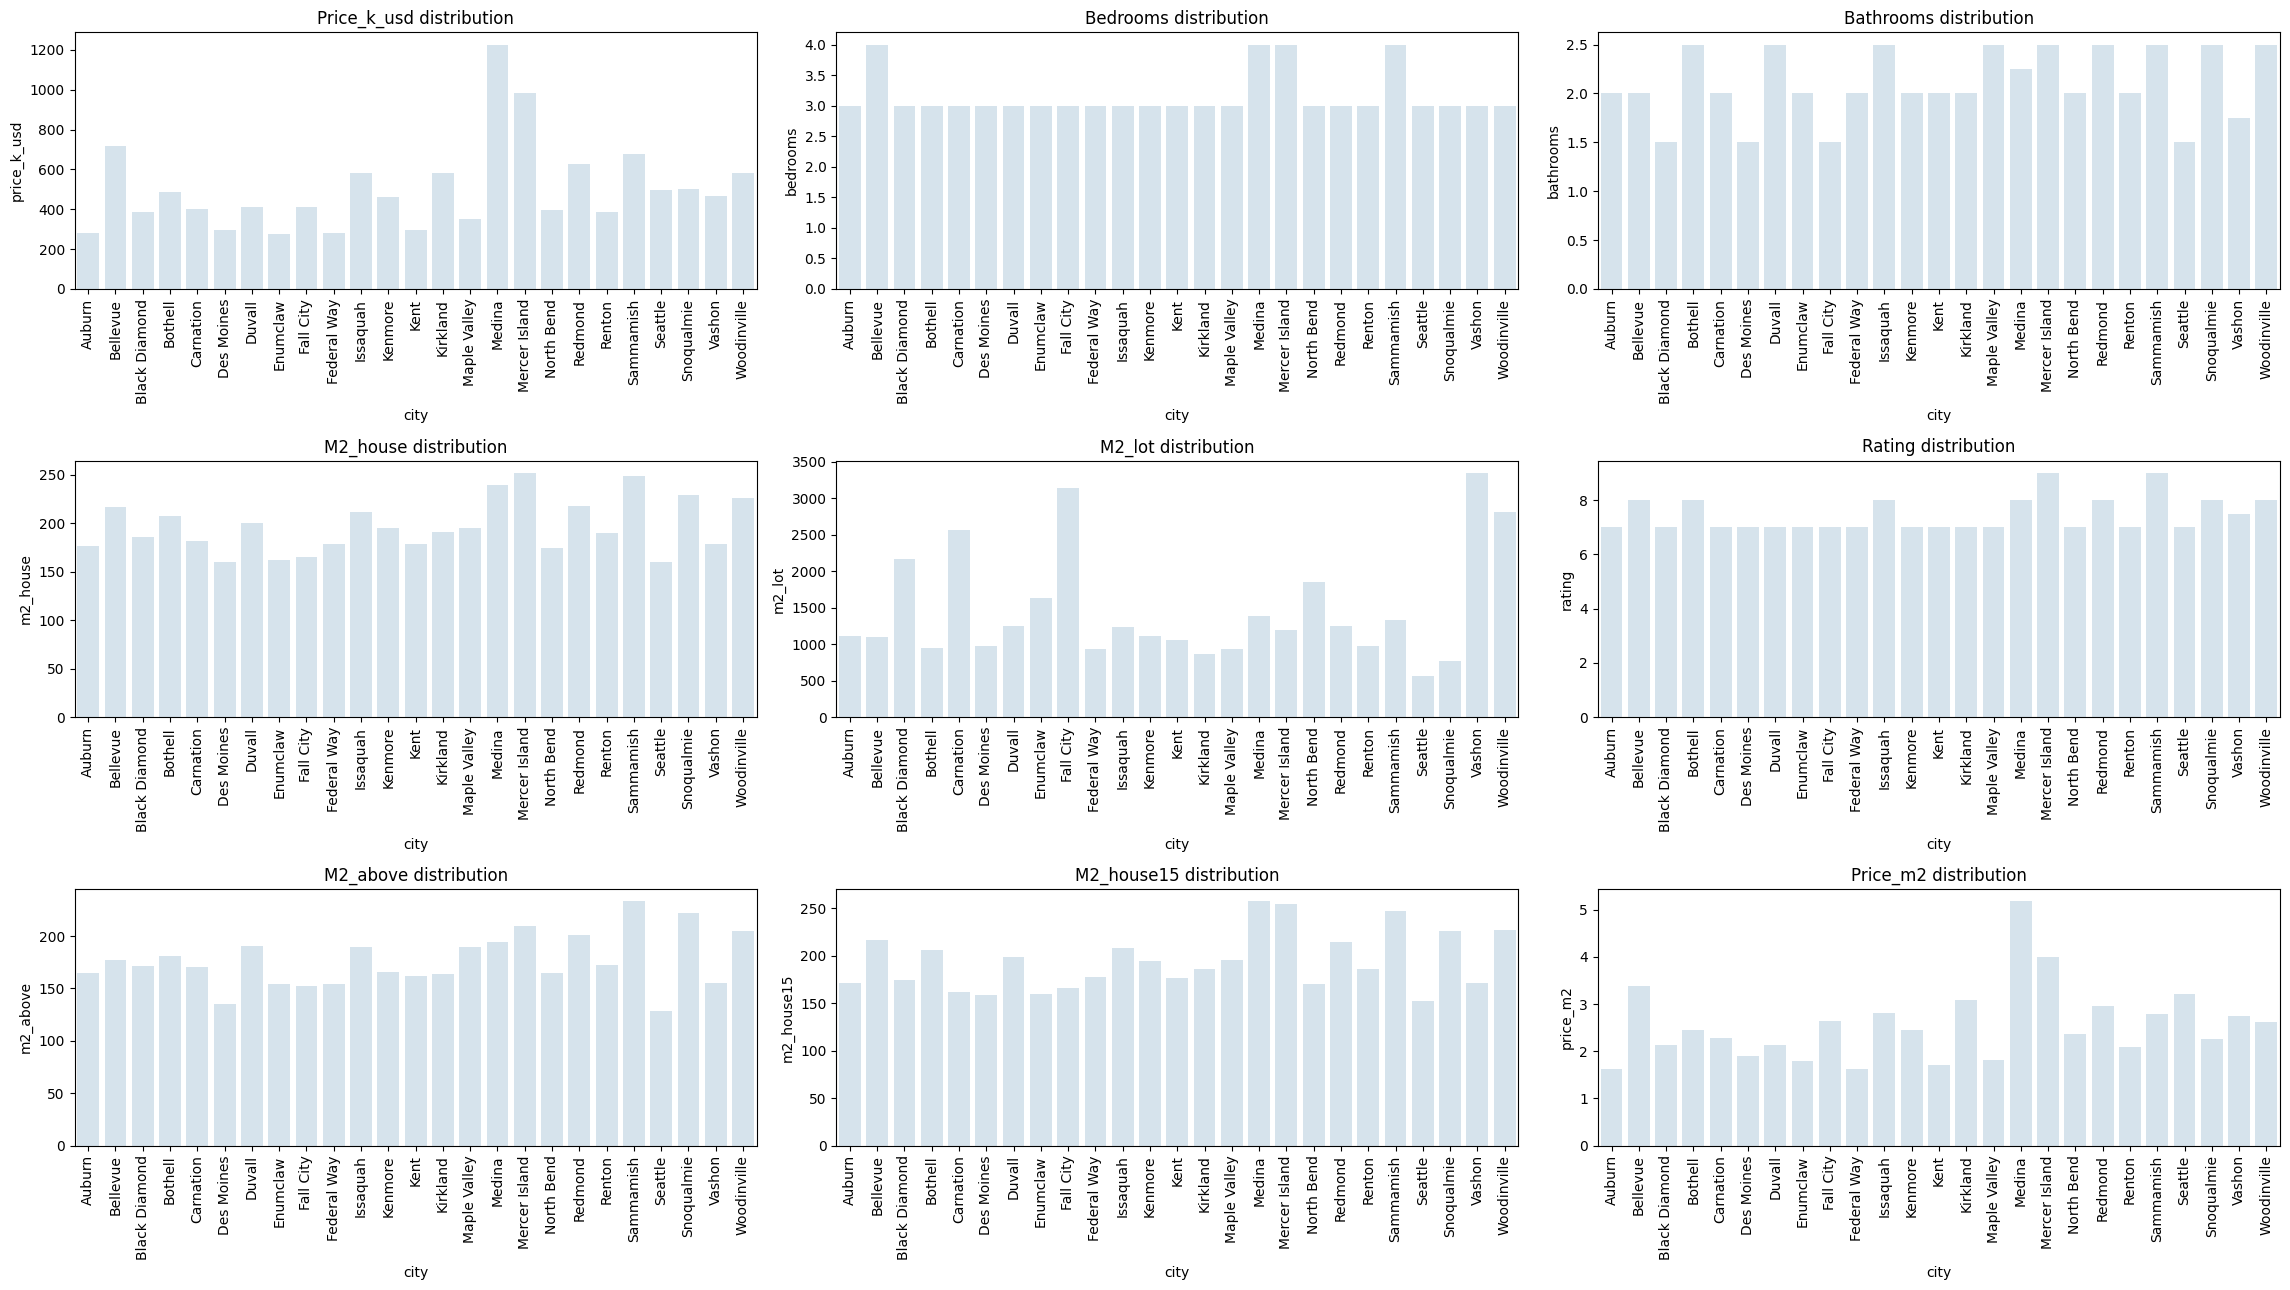

In [ ]:
get_barplot(by_city)

Como podemos apreciar, la categoria ciudad si representa en algunas variables tendencias bastante marcadas o diferencias notables entre ciudades. Por ejemplo a nivel de precio en miles de dolares y precio/m2, cantidad de dormitorios, m2 totales, rating y m2house15, ciudades como Medina sobresalen del resto, por lo que sería interesante entregarle estas variables al algoritmo.

#3**.Aplicar técnicas de transformación de datos, como normalización o estandarización, para asegurar que las variables estén en una escala comparable. Luego de ello,divide el conjunto de datos en conjuntos de entrenamiento y prueba de manera aleatoria o estratificada.**

Algunas consideraciones: Para evitar multicolinealidad, dropearemos las variables que explican las mismas caracteristicas o que fueron creadas a partir de otras. Por ejemplo, podemos eliminar m2_above y m2_basement ya que ambas estan incluidas dentro de m2_house

In [ ]:
#Creamos el df para entregarle al algoritmo, ejecutando las transformaciones necesarias

#Dropeamos algunas columnas para evitar multicolinealidad
df_alg = df_clean.drop(columns=["id","lat","long","yr_built","condition","price_m2","m2_above","m2_basement",])

#Extraemos año y mes desde la fecha
df_alg["year"] = df_alg["date"].dt.year
df_alg["month"] = df_alg["date"].dt.month

#Hacemos un label encoder para poder conservar la variable categorica city, ya que como vimos anteriormente si presenta algún tipo de diferencia estadistica
label_encoder = LabelEncoder()
df_alg["city"]= label_encoder.fit_transform(df_alg["city"])

#Dropeamos la fecha
df_alg = df_alg.drop(columns="date")

df_alg

,price_k_usd,bedrooms,bathrooms,m2_house,m2_lot,floors,waterfront,view,rating,m2_house15,m2_lot15,city,last_renovate_yr,year,month
0,221.9,3,1.0,109.63,524.90,1.0,0,0,7,124.49,524.90,21,0,2014,10
2,180.0,2,1.0,71.54,929.03,1.0,0,0,6,252.70,748.99,11,0,2015,2
3,604.0,4,3.0,182.09,464.52,1.0,0,0,7,126.35,464.52,21,0,2014,12
4,510.0,3,2.0,156.08,750.66,1.0,0,0,8,167.23,697.05,20,0,2015,2
6,257.5,3,2.0,159.33,633.51,2.0,0,0,7,207.92,633.51,9,0,2014,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21606,1007.5,4,3.5,326.09,668.90,2.0,0,0,9,190.45,576.00,21,0,2015,3
21607,475.0,3,2.5,121.70,120.22,2.0,0,0,8,123.56,117.52,21,0,2015,2
21608,360.0,3,2.5,142.14,105.07,3.0,0,0,8,142.14,140.19,21,0,2014,5
21609,400.0,4,2.5,214.61,540.05,2.0,0,0,8,170.01,668.90,21,0,2015,2


**Estandarizaremos la data y dividiremos el dataset**

In [ ]:
#Definimos el target y las variables predictoras
X= df_alg.drop(columns="price_k_usd")
y= df_alg["price_k_usd"]

#Dividimos en train y test
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.30, random_state=16)

#Instanciamos la estandarizacion
sc = StandardScaler()

#Ajustamos el scaler solo a train, importante!
sc.fit(X_train)

#Transformamos X_train y X_test
X_train_scaled = sc.transform(X_train)
X_test_scaled = sc.transform(X_test)

**Para validar la elección de las variables, obtendremos los valores de los coeficientes por cada columna:**

In [ ]:
#Instanciamos el modelo de regresion lineal de testeo
model_test = LinearRegression()
model_test.fit(X_train_scaled,y_train)

colnames = X_train.columns

coef = model_test.coef_
coef_df = pd.DataFrame({'Feature': colnames, 'Coeficiente': coef})
coef_df

,Feature,Coeficiente
0,bedrooms,-7.861276
1,bathrooms,-13.620851
2,m2_house,93.125589
3,m2_lot,3.633939
4,floors,-8.945224
5,waterfront,6.351397
6,view,28.778641
7,rating,90.815183
8,m2_house15,19.492547
9,m2_lot15,-19.169245


Como podemos ver, en gran medida las variables consideradas si cuentan con coeficientes que reflejan algún tipo de influencia sobre la variable precio, por lo que seguiremos adelante en la aplicacion de testeo de hiperparametros.

#**4.Implementar modelos de regresión lineal con regularización, como Ridge, Lasso o Elastic Net y ajuste los hiper parámetros mostrando como se mueve los hiperparametros y el ajuste. Además, debes construir modelos de árboles de regresión para capturar relaciones no lineales y complejas entre las variables predictoras y el precio de las casas. y 5.Utilizar métricas de evaluación de regresión, como el Error Cuadrático Medio (MSE), el Error Absoluto Medio (MAE) y el Coeficiente de Determinación (R²), para medir el rendimiento del modelo y concluir sobre ellos.**

Linear Regression & Decision Tree Regressor, haremos busqueda de hiperparametros y veremos sus metricas de desempeño

In [ ]:
def find_best_model(X, y):
    # Hiperparametros
    ridge_params = {"alpha": [0.001, 0.01, 0.1, 1, 10, 15, 20]}
    lasso_params = {"alpha": [0.001, 0.01, 0.1, 1, 10]}
    elastic_params = {"alpha": [0.001, 0.01, 0.1, 1, 10], "l1_ratio": [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}

    tree_params = {
        "min_samples_leaf": [1, 2, 4],
        "min_samples_split": [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55 , 60 , 65,70],
        "max_depth": [None, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90],
        }

    lasso = Lasso(max_iter=1000)
    ridge = Ridge(max_iter=1000)
    elastic = ElasticNet(max_iter=1000)
    dt_reg = DecisionTreeRegressor()

    models = [lasso, ridge, elastic, dt_reg]
    params = [ridge_params, lasso_params, elastic_params, tree_params]
    best_model, best_params, best_score = None, None, float("-inf")

    # Entrenamiento
    for model, param_grid in zip(models, params):
        grid = GridSearchCV(model, param_grid, cv=5, scoring="r2").fit(X, y) #Usamos un R2 para poder interpretar de mejor manera que modelo es mejor, luego haremos el calculo de todas las metricas

        if grid.best_score_ > best_score:
            best_score = grid.best_score_
            best_model = model
            best_params = grid.best_params_


        #Estos prints se pueden eliminar si solo queremos que retorne el mejor, pero los dejaremos para poder ver como se comporta cada modelo
        print("Model:", grid.best_estimator_)
        print("Best params:", grid.best_params_)
        print("R2:", grid.best_score_)
        print("=" * 100)

    return best_model, best_params, best_score


Aplicamos la funcion y obtenermos los resultados de los 4 algoritmos

In [ ]:
best_model, best_params, best_score = find_best_model(X_train_scaled,y_train)

Model: Lasso(alpha=0.001)
Best params: {'alpha': 0.001}
R2: 0.5443674303453037
Model: Ridge(alpha=10, max_iter=1000)
Best params: {'alpha': 10}
R2: 0.5443689104587918
Model: ElasticNet(alpha=0.001, l1_ratio=0.1)
Best params: {'alpha': 0.001, 'l1_ratio': 0.1}
R2: 0.5443688886748796
Model: DecisionTreeRegressor(max_depth=40, min_samples_leaf=4, min_samples_split=60)
Best params: {'max_depth': 40, 'min_samples_leaf': 4, 'min_samples_split': 60}
R2: 0.6812555816292424


Resultados preliminares validacion cruzada:


*   **Modelos de regresion lineal L1, L2 y ElasticNet:**
*Los 3 modelos de esta clase cuentan con rendimientos bastante similares a nivel de r2, mse, rmse. En este caso consideramos r2 al ser más interpretable y teniendo en cuenta un rendimiento del 54%, podemos afirmar que estos modelos de regresion lineal no son capaces de explicar la variabilidad del precio de las casas en base a las features entregadas.*

*   **Decision Tree Regressor:**
*Con un r2 de 0.68, podemos afirmar que presenta mejores metricas de desempeño que las regresiones lineales, esto puede deberse a multiples factores propios de la forma en que clasifica el arbol, incluyendo que este algoritmo es capaz de captar las relaciones no lineales de las caracteristicas, como por ejemplo, el año, el mes, la ciudad, por lo que será el algoritmo con el que avanzaremos usando sus hiperparametros y luego mediremos sus r2,mse,rmse,mape,mae en train y test.*



Decision Tree Regressor, con los hiperparametros testeados.

In [ ]:
#Instanciamos el algoritmo
dt = DecisionTreeRegressor(max_depth= 85 , min_samples_leaf= 4, min_samples_split= 60,criterion="squared_error",max_features=1.0,random_state=16)

#Ajustamos
dt.fit(X_train_scaled,y_train)

#==============Predicciones==========================

#Precimos sobre train
y_train_pred = dt.predict(X_train_scaled)

#Precimos sobre test
y_test_pred = dt.predict(X_test_scaled)

#==============METRICAS DE EVALUACION=================

#Mean Squared Error (MSE)
mse_train = mean_squared_error(y_train,y_train_pred)
mse_test = mean_squared_error(y_test,y_test_pred)

#Root Mean Squared Error (RMSE)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)

#Mean Absolute Error (MAE)
mae_train = mean_absolute_error(y_train,y_train_pred)
mae_test = mean_absolute_error(y_test,y_test_pred)

#Mean Absolute Percentage Error (MAPE)
mape_train = mean_absolute_percentage_error(y_train,y_train_pred)
mape_test = mean_absolute_percentage_error(y_test,y_test_pred)

#R-quared coefficient (r2)
r2_train = r2_score(y_train,y_train_pred)
r2_test = r2_score(y_test,y_test_pred)

Graficamos las metricas de evaluacion de test y train.

In [ ]:
#==========METRICAS SOBRE TRAIN========================
print("METRICAS SOBRE TRAIN:")
print("")
print("MSE TRAIN:", round(mse_train,3))
print("RMSE TRAIN:", round(rmse_train,3))
print("MAE TRAIN:", round(mae_train,3))
print("MAPE TRAIN:", round(mape_train,3))
print("r2 TRAIN:", round(r2_train,3))
#==========METRICAS SOBRE TEST========================
print("")
print("METRICAS SOBRE TEST:")
print("")
print("MSE TEST:", round(mse_test,3))
print("RMSE TEST:", round(rmse_test,3))
print("MAE TEST:", round(mae_test,3))
print("MAPE TEST:", round(mape_test,3))
print("r2 TEST:", round(r2_test,3))




METRICAS SOBRE TRAIN:

MSE TRAIN: 11952.656
RMSE TRAIN: 109.328
MAE TRAIN: 74.078
MAPE TRAIN: 0.163
r2 TRAIN: 0.789

METRICAS SOBRE TEST:

MSE TEST: 16492.372
RMSE TEST: 128.423
MAE TEST: 88.038
MAPE TEST: 0.196
r2 TEST: 0.708


**Resultados finales**

Luego de ver todas las metricas de evaluacion para un algoritmo regresivo, como en este caso del arbol de decision regresor, podemos afirmar que tanto en test como en train, el modelo presenta un entre un 70-78% de capacidad para poder explicar la variabilidad del precio de las casas a partir de las features que se le entregaron. Sin embargo, si visualizamos todas las metricas de error, por la magnitud de estos, podemos afirmar que el modelo no es lo suficientemente confiable como para poder predecir el precio de las viviendas, sobre todo por medidas como RMSE, que indica que el modelo se desvia aproximadamente unos 128k de dolares con respecto al valor real de la propiedad, lo que esta muy lejos de ser un parametro aceptable. A pesar del "mal" desempeño a nivel de error del modelo, podemos tambien rescatar el como el algoritmo escaló de un r2 de 0.5, a casi 0.8 al incluirle features categoricas, ya que este algoritmo es capaz de interpretar y detectar las relaciones no lineales entre las caracteristicas. Seria interesante posteriormente probar con otro tipo de algoritmos, como un SVM para testear si se comporta mejor que el arbol de regresion.